In [4]:
import requests
import json
import pandas as pd
import re
import spacy
import numpy as np
import string
import stanza
#import ete4
from nltk.translate import Alignment, AlignedSent, IBMModel1
from nltk.corpus import comtrans
from nltk.metrics import precision
from nltk.metrics import recall
from nltk.translate import alignment_error_rate
from simalign import SentenceAligner
from tqdm import tqdm
import networkx as nx

# Reading in Data

In [5]:
ill_eng_grk_align_url = 'https://github.com/scaife-viewer/beyond-translation-site/raw/main/backend/data/annotations/text-alignments/iliad-word-alignment-parrish-998078bc3bab42978b47fa8e8b852cae.json'
ill_eng_grk_align_resp = requests.get(ill_eng_grk_align_url)
ill_eng_grk_align = json.loads(ill_eng_grk_align_resp.text)

In [6]:
len(ill_eng_grk_align['records'])

5419

In [7]:
eng_toks = {}
eng_sen = {}
url='https://raw.githubusercontent.com/scaife-viewer/beyond-translation-site/main/backend/data/library/tlg0012/tlg001/tlg0012.tlg001.'+'parrish-eng1'+'.txt'
text=requests.get(url).text.split("\n")
lines=[]
for line in text[:-1]:
    line_num = re.search(r'\d+\.\d+',line).group()
    lines.append(line_num)

    tokens = re.split(re.search(r'\d+\.\d+',line).group(),line)[1].translate(str.maketrans('', '', string.punctuation)).split()
    
    eng_toks[line_num] = tokens
    eng_sen[line_num] = re.split(re.search(r'\d+\.\d+',line).group(),line)[1][1:].translate(str.maketrans('', '', string.punctuation))
    

In [8]:
grk_toks = {}
grk_sen = {}
url='https://raw.githubusercontent.com/scaife-viewer/beyond-translation-site/main/backend/data/library/tlg0012/tlg001/tlg0012.tlg001.'+'perseus-grc2'+'.txt'
text=requests.get(url).text.split("\n")

for line in text[:-1]:
    line_num = re.search(r'\d+\.\d+',line).group()


    tokens = re.split(re.search(r'\d+\.\d+',line).group(),line)[1].split()
    
    grk_toks[line_num] = tokens
    grk_sen[line_num] = re.split(re.search(r'\d+\.\d+',line).group(),line)[1][1:]
    

In [9]:
alignment={}
for record in ill_eng_grk_align['records']:
    urn_prefix ='urn:cts:greekLit:tlg0012.tlg001.'
    #relations = record['relations']
    #urn=relations[1][0]
    #trimmed_urn = re.split(urn_prefix, urn)[1]
    
    #source (greek) 
    #english tokens
    eng_toks_urns = record['relations'][0]
    #greek tokens
    grk_toks_urns = record['relations'][1]
    # go through each greek token and add all the english tokens
    #print(grk_toks_urns)
    for eng_tok_urn in eng_toks_urns:
        eng_tok_id = re.split(urn_prefix, eng_tok_urn)[1].split(':')[-1]
        grk_tok_ids = []
        for grk_tok_urn in grk_toks_urns:
            #print(eng_tok_urn)
            grk_tok_id = re.split(urn_prefix, grk_tok_urn)[1].split(':')[-1]
            grk_tok_ids.append(grk_tok_id)
        alignment[eng_tok_id] = grk_tok_ids
            
            

In [10]:
line_num ='1.1'
for tok_num in range(len(eng_toks[line_num])):
    print("\n"+eng_toks[line_num][tok_num])
    tk_id = tok_num+1
    for grk_tok_id in alignment[line_num+'.t'+str(tk_id)]:
        print(grk_toks[grk_tok_id.split('t')[0][:-1]][int(grk_tok_id.split('t')[-1])-1])


Sing
ἄειδε

goddess
θεὰ

the

godlike
μῆνιν

wrath
μῆνιν

of
Ἀχιλῆος

Achilles
Ἀχιλῆος

son
Πηληϊάδεω

of
Πηληϊάδεω

Peleus
Πηληϊάδεω


In [11]:
alignment['1.1.t1']

['1.1.t2']

In [12]:
grk_sen['1.1']

'μῆνιν ἄειδε θεὰ Πηληϊάδεω Ἀχιλῆος'

In [13]:
grk_toks['1.1']

['μῆνιν', 'ἄειδε', 'θεὰ', 'Πηληϊάδεω', 'Ἀχιλῆος']

In [14]:
eng_sen['1.1']

'Sing goddess the godlike wrath of Achilles son of Peleus'

In [15]:
eng_toks['1.1']

['Sing',
 'goddess',
 'the',
 'godlike',
 'wrath',
 'of',
 'Achilles',
 'son',
 'of',
 'Peleus']

## Tree building

In [16]:
grk_stanza = stanza.Pipeline(lang='grc', processors='tokenize,pos,lemma,depparse')
eng_stanza = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')

2024-04-08 20:42:03 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-04-08 20:42:04 INFO: Downloaded file to C:\Users\josep\stanza_resources\resources.json
2024-04-08 20:42:05 INFO: Loading these models for language: grc (Ancient_Greek):
| Processor | Package          |
--------------------------------
| tokenize  | perseus          |
| pos       | perseus_nocharlm |
| lemma     | perseus_nocharlm |
| depparse  | perseus_nocharlm |

2024-04-08 20:42:05 INFO: Using device: cpu
2024-04-08 20:42:05 INFO: Loading: tokenize
2024-04-08 20:42:06 INFO: Loading: pos
2024-04-08 20:42:06 INFO: Loading: lemma
2024-04-08 20:42:06 INFO: Loading: depparse
2024-04-08 20:42:07 INFO: Done loading processors!
2024-04-08 20:42:07 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with downloa

In [17]:
grk_doc = grk_stanza(grk_sen['1.2'].translate(str.maketrans('', '', string.punctuation)))

In [18]:
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in grk_doc.sentences for word in sent.words], sep='\n')

id: 1	word: οὐλομένην	head id: 6	head: ἔθηκε	deprel: xcomp
id: 2	word: ἣ	head id: 6	head: ἔθηκε	deprel: nsubj
id: 3	word: μυρίʼ	head id: 4	head: Ἀχαιοῖς	deprel: case
id: 4	word: Ἀχαιοῖς	head id: 6	head: ἔθηκε	deprel: obl
id: 5	word: ἄλγεʼ	head id: 6	head: ἔθηκε	deprel: advmod
id: 6	word: ἔθηκε	head id: 0	head: root	deprel: root


In [19]:
for sent in grk_doc.sentences:
    for word in sent.words:
        print('t'+str(word.id),word.text,'t'+str(word.head))

t1 οὐλομένην t6
t2 ἣ t6
t3 μυρίʼ t4
t4 Ἀχαιοῖς t6
t5 ἄλγεʼ t6
t6 ἔθηκε t0


In [20]:
eng_doc = eng_stanza(eng_sen['1.1'])

In [21]:
print(*[f'id: {word.id}\tword: {word.text}\thead id: {word.head}\thead: {sent.words[word.head-1].text if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in eng_doc.sentences for word in sent.words], sep='\n')

id: 1	word: Sing	head id: 0	head: root	deprel: root
id: 2	word: goddess	head id: 1	head: Sing	deprel: obj
id: 3	word: the	head id: 5	head: wrath	deprel: det
id: 4	word: godlike	head id: 5	head: wrath	deprel: amod
id: 5	word: wrath	head id: 1	head: Sing	deprel: obj
id: 6	word: of	head id: 7	head: Achilles	deprel: case
id: 7	word: Achilles	head id: 5	head: wrath	deprel: nmod
id: 8	word: son	head id: 7	head: Achilles	deprel: flat
id: 9	word: of	head id: 10	head: Peleus	deprel: case
id: 10	word: Peleus	head id: 8	head: son	deprel: nmod


In [22]:
for sent in eng_doc.sentences:
    for word in sent.words:
        print('t'+str(word.id),word.text,'t'+str(word.head))

t1 Sing t0
t2 goddess t1
t3 the t5
t4 godlike t5
t5 wrath t1
t6 of t7
t7 Achilles t5
t8 son t7
t9 of t10
t10 Peleus t8


In [23]:
def buildTree(doc):
    ud_tree = dict()
    for sent in doc.sentences:
        for word in sent.words:
            children=[]
            for token in sent.words:
                #print(token.text,token.head)
                if token.head==word.id:
                    children.append('t'+str(token.id))
            #print(word.id,children)
            ud_tree['t'+str(word.id)] = [word.text, word.id, word.deprel, children]
    return ud_tree

In [24]:
eng_tree=buildTree(eng_doc)

In [25]:
grk_tree=buildTree(grk_doc)

In [26]:
grk_sen['1.1']

'μῆνιν ἄειδε θεὰ Πηληϊάδεω Ἀχιλῆος'

In [27]:
tree_dict=dict()
for key in tqdm(eng_sen.keys()):
    eng_doc = eng_stanza(eng_sen[key])
    grk_doc = grk_stanza(grk_sen[key].translate(str.maketrans('', '', string.punctuation)))
    
    eng_tree = buildTree(eng_doc)
    grk_tree = buildTree(grk_doc)
    
    tree_dict[key]=(grk_tree,eng_tree)    

100%|████████████████████████████████████████████████████████████████████████████████| 607/607 [03:58<00:00,  2.54it/s]


In [28]:
import pickle

with open('tree_dic.pkl', 'wb') as f:
    pickle.dump(tree_dict, f)


In [29]:
eng_graphs={}
grk_graphs={}
for sent in tqdm(tree_dict.keys()):
    sentence = tree_dict[sent]
    eng_tree=sentence[1]
    grk_tree=sentence[0]
    G_e = nx.DiGraph()
    for key in eng_tree.keys():
        token = eng_tree[key]
        #print(token[2])
        G_e.add_node(key, role=token[2])
        for child in token[3]:
            G_e.add_edge(key,child)
    eng_graphs[sent]=G_e
    G_g = nx.DiGraph()
    for key in grk_tree.keys():
        token = grk_tree[key]
        G_g.add_node(key, role=token[2])
        for child in token[3]:
            G_g.add_edge(key,child)
    grk_graphs[sent]=G_g

100%|█████████████████████████████████████████████████████████████████████████████| 607/607 [00:00<00:00, 18588.95it/s]


In [30]:
tree_dict['1.2']

({'t1': ['οὐλομένην', 1, 'xcomp', []],
  't2': ['ἣ', 2, 'nsubj', []],
  't3': ['μυρίʼ', 3, 'case', []],
  't4': ['Ἀχαιοῖς', 4, 'obl', ['t3']],
  't5': ['ἄλγεʼ', 5, 'advmod', []],
  't6': ['ἔθηκε', 6, 'root', ['t1', 't2', 't4', 't5']]},
 {'t1': ['that', 1, 'det', []],
  't2': ['sociopathic', 2, 'amod', []],
  't3': ['wrath', 3, 'root', ['t1', 't2', 't5']],
  't4': ['that', 4, 'nsubj', []],
  't5': ['caused', 5, 'acl:relcl', ['t4', 't7']],
  't6': ['countless', 6, 'amod', []],
  't7': ['pains', 7, 'obj', ['t6', 't10']],
  't8': ['for', 8, 'case', []],
  't9': ['the', 9, 'det', []],
  't10': ['Achaeans', 10, 'nmod', ['t8', 't9']]})

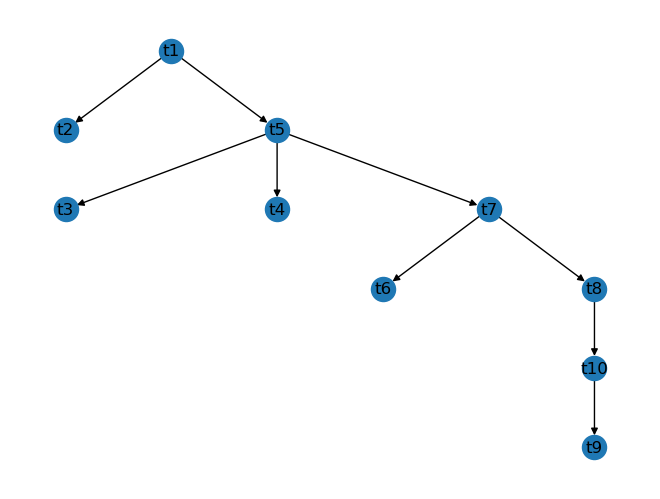

In [229]:
sample_tree=eng_graphs['1.1']

value = {i for i in tree_dict['1.1'][1] if tree_dict['1.1'][1][i][2]=="root"}
for val in value:
    root=val
nx.draw(sample_tree,pos=nx.nx_agraph.graphviz_layout(sample_tree, prog='dot', root=root, args=''),with_labels=True)

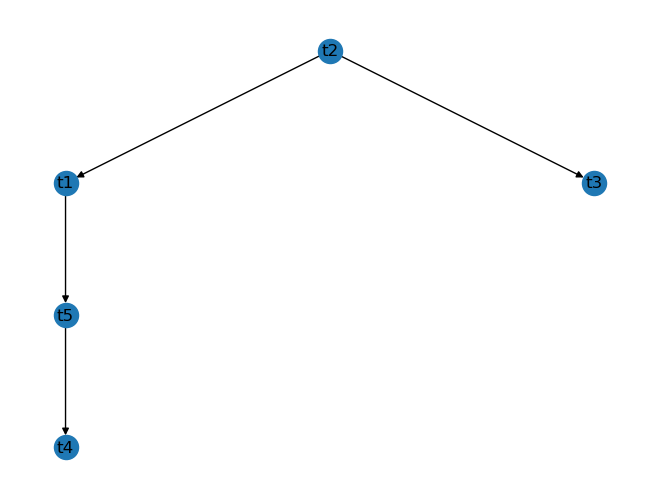

In [230]:
sample_tree=grk_graphs['1.1']

value = {i for i in tree_dict['1.1'][0] if tree_dict['1.1'][0][i][2]=="root"}
for val in value:
    root=val
nx.draw(sample_tree,pos=nx.nx_agraph.graphviz_layout(sample_tree, prog='dot', root=root, args=''),with_labels=True)

In [232]:
eng_sen['1.1']

'Sing goddess the godlike wrath of Achilles son of Peleus'

In [34]:
tree_dict['1.2']

({'t1': ['οὐλομένην', 1, 'xcomp', []],
  't2': ['ἣ', 2, 'nsubj', []],
  't3': ['μυρίʼ', 3, 'case', []],
  't4': ['Ἀχαιοῖς', 4, 'obl', ['t3']],
  't5': ['ἄλγεʼ', 5, 'advmod', []],
  't6': ['ἔθηκε', 6, 'root', ['t1', 't2', 't4', 't5']]},
 {'t1': ['that', 1, 'det', []],
  't2': ['sociopathic', 2, 'amod', []],
  't3': ['wrath', 3, 'root', ['t1', 't2', 't5']],
  't4': ['that', 4, 'nsubj', []],
  't5': ['caused', 5, 'acl:relcl', ['t4', 't7']],
  't6': ['countless', 6, 'amod', []],
  't7': ['pains', 7, 'obj', ['t6', 't10']],
  't8': ['for', 8, 'case', []],
  't9': ['the', 9, 'det', []],
  't10': ['Achaeans', 10, 'nmod', ['t8', 't9']]})

## Generating graph alignments

In [169]:
def compute_matches(tree_1, tree_2, root_1, root_2):
    alignments=[]
    #match roots
    #print(root_1,root_2)
    alignments.append((root_1,root_2))

    #rank children by subtree size
    ranks_1=[]
    for child in tree_1.successors(root_1):
        subtree_size = len(nx.dfs_tree(tree_1, source=child).nodes())
        ranks_1.append([child,subtree_size])
    ranks_1.sort(key = lambda x: x[1], reverse=True)
    #print(ranks_1)
    ranks_2=[]
    for child in tree_2.successors(root_2):
        subtree_size = len(nx.dfs_tree(tree_2, source=child).nodes())
        ranks_2.append([child,subtree_size])
    ranks_2.sort(key = lambda x: x[1], reverse=True)
    #print(ranks_2)

    #match by rank
    child_diff=len(ranks_1)-len(ranks_2)

    #root 2 has more children or the same number
    if(child_diff<=0):
        for child_idx in range(len(ranks_1)):
            matches=compute_matches(nx.dfs_tree(tree_1, source=ranks_1[child_idx][0]),nx.dfs_tree(tree_2, source=ranks_2[child_idx][0]),ranks_1[child_idx][0],ranks_2[child_idx][0])
            for match in matches:
                alignments.append(match)

    #leftovers match to root
        if(child_diff<0):
            for leftover_2 in range(len(ranks_1),len(ranks_2)):
                for descendent in nx.dfs_tree(tree_2, source=ranks_2[leftover_2][0]).nodes():
                    alignments.append((root_1,descendent))
    else:
        for child_idx in range(len(ranks_2)):
            matches=compute_matches(nx.dfs_tree(tree_1, source=ranks_1[child_idx][0]),nx.dfs_tree(tree_2, source=ranks_2[child_idx][0]),ranks_1[child_idx][0],ranks_2[child_idx][0])
            for match in matches:
                alignments.append(match)

        #print(len(ranks_2),len(ranks_1))
        for leftover_1 in range(len(ranks_2),len(ranks_1)):
            for descendent in nx.dfs_tree(tree_1, source=ranks_1[leftover_1][0]).nodes():
                alignments.append((descendent,root_2))  
    return list(set(alignments))
    

In [170]:
def convert_graph_alignment(graph_alignment):
    new_align=[]
    for pair in graph_alignment:
        new_align.append((int(pair[0].split('t')[1])-1,int(pair[1].split('t')[1])-1))
    return Alignment(new_align)

In [176]:
value = {i for i in nx.get_node_attributes(eng_graphs['1.1'],'role') if nx.get_node_attributes(eng_graphs['1.1'],'role')[i]=="root"}
for val in value:
    root_1=val
value = {i for i in nx.get_node_attributes(grk_graphs['1.1'],'role') if nx.get_node_attributes(grk_graphs['1.1'],'role')[i]=="root"}
for val in value:
    root_2=val
compute_matches(eng_graphs['1.1'],grk_graphs['1.1'], root_1, root_2)

[('t5', 't1'),
 ('t4', 't1'),
 ('t1', 't2'),
 ('t6', 't5'),
 ('t9', 't4'),
 ('t10', 't4'),
 ('t2', 't3'),
 ('t7', 't5'),
 ('t8', 't4'),
 ('t3', 't1')]

In [184]:
value = {i for i in nx.get_node_attributes(eng_graphs['1.2'],'role') if nx.get_node_attributes(eng_graphs['1.2'],'role')[i]=="root"}
for val in value:
    root_1=val
value = {i for i in nx.get_node_attributes(grk_graphs['1.2'],'role') if nx.get_node_attributes(grk_graphs['1.2'],'role')[i]=="root"}
for val in value:
    root_2=val
compute_matches(eng_graphs['1.2'],grk_graphs['1.2'], root_1, root_2)

[('t7', 't3'),
 ('t9', 't3'),
 ('t10', 't3'),
 ('t1', 't1'),
 ('t5', 't4'),
 ('t8', 't3'),
 ('t3', 't6'),
 ('t2', 't2'),
 ('t6', 't3'),
 ('t3', 't5'),
 ('t4', 't4')]

In [190]:
graph_alignment=compute_matches(eng_graphs['1.2'],grk_graphs['1.2'], root_1, root_2)
convert_graph_alignment(graph_alignment)

Alignment([(0, 0), (1, 1), (2, 4), (2, 5), (3, 3), (4, 3), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2)])

In [192]:
aligned_lines['1.1'].alignment

Alignment([(0, 1), (1, 2), (3, 0), (4, 0), (5, 4), (6, 4), (7, 3), (8, 3), (9, 3)])

In [193]:
graph_alignments['1.1']

Alignment([(0, 1), (1, 2), (2, 0), (3, 0), (4, 0), (5, 4), (6, 4), (7, 3), (8, 3), (9, 3)])

In [188]:
graph_alignments={}
for key in tqdm(eng_sen.keys()):
    eng_graph = eng_graphs[key]
    grk_graph = grk_graphs[key]

    value = {i for i in nx.get_node_attributes(eng_graph,'role') if nx.get_node_attributes(eng_graph,'role')[i]=="root"}
    for val in value:
        root_e=val
    value = {i for i in nx.get_node_attributes(grk_graph,'role') if nx.get_node_attributes(grk_graph,'role')[i]=="root"}
    for val in value:
        root_g=val
        
    graph_align=compute_matches(eng_graph,grk_graph, root_e, root_g)
    graph_alignments[key]=convert_graph_alignment(graph_align)

100%|██████████████████████████████████████████████████████████████████████████████| 607/607 [00:00<00:00, 2153.01it/s]


# Evaluation

### Gold Standard

In [43]:
aligned_lines={}
for key in tqdm(eng_sen.keys()):
    align_list=[]
    for token_idx in range(len(eng_toks[key])):
        try:
            aligned_tokens = alignment[key+'.t'+str(token_idx+1)]
        except:
            aligned_tokens = []
        for aligned_token in aligned_tokens:
            if aligned_token != None:
                align_list.append((token_idx,int(aligned_token.split(key+'.t')[1])-1))
    aligned_line = AlignedSent(eng_toks[key],grk_toks[key],Alignment(align_list))
    aligned_lines[key]=aligned_line

100%|████████████████████████████████████████████████████████████████████████████| 607/607 [00:00<00:00, 100997.40it/s]


In [44]:
aligned_lines['1.2'].alignment

Alignment([(1, 0), (3, 1), (4, 5), (5, 2), (6, 4), (9, 3)])

## Graph Topology

In [194]:
precision_score=0
recall_score=0
AER_score=0
for key in tqdm(eng_sen.keys()):
    precision_score+=precision(graph_alignments[key],aligned_lines[key].alignment)
    recall_score+=recall(graph_alignments[key],aligned_lines[key].alignment)
    AER_score+=alignment_error_rate(graph_alignments[key],aligned_lines[key].alignment)
precision_score=precision_score/len(eng_sen.keys())
recall_score=recall_score/len(eng_sen.keys())
AER_score=AER_score/len(eng_sen.keys())

100%|████████████████████████████████████████████████████████████████████████████| 607/607 [00:00<00:00, 187160.37it/s]


In [195]:
precision_score

0.2703009447919009

In [196]:
recall_score

0.21806459602692652

In [197]:
AER_score

0.7618687161203436

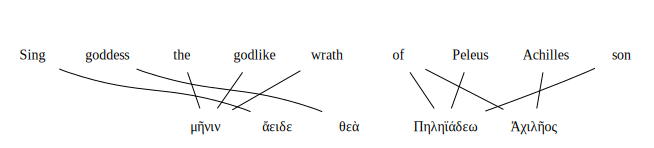

In [233]:
AlignedSent(eng_toks['1.1'],grk_toks['1.1'],graph_alignments['1.1'])

## UGARIT Autoalign

In [204]:
import torch
import transformers
import itertools
from nltk import word_tokenize
import numpy as np

def align_sentence(src,
                   tgt,
                   model_name='UGARIT/grc-alignment',
                   match="softmax", # possible values ["softmax", "argmax"]
                   align_layer=8):
    
    # Load the model
    model = transformers.XLMRobertaForMaskedLM.from_pretrained(model_name)
    tokenizer = transformers.XLMRobertaTokenizer.from_pretrained(model_name)

    # tokenizing, first phase
    sent_src = word_tokenize(src.strip())  
    sent_tgt = word_tokenize(tgt.strip())  

    token_src = [tokenizer.tokenize(word) for word in sent_src]
    token_tgt = [tokenizer.tokenize(word) for word in sent_tgt]
    
    wid_src = [tokenizer.convert_tokens_to_ids(x) for x in token_src]
    wid_tgt = [tokenizer.convert_tokens_to_ids(x) for x in token_tgt]

    ids_src = tokenizer.prepare_for_model(list(itertools.chain(*wid_src)), return_tensors='pt',
                                          model_max_length=tokenizer.model_max_length, truncation=True)['input_ids']
    ids_tgt = tokenizer.prepare_for_model(list(itertools.chain(*wid_tgt)), return_tensors='pt',
                                          truncation=True, model_max_length=tokenizer.model_max_length)['input_ids']

    sub2word_map_src = []
    for i, word_list in enumerate(token_src):
        sub2word_map_src += [i for x in word_list]

    sub2word_map_tgt = []
    for i, word_list in enumerate(token_tgt):
        sub2word_map_tgt += [i for x in word_list]

    # alignment
    threshold = 1e-3
    model.eval()

    with torch.no_grad():
        out_src = model(ids_src.unsqueeze(0), output_hidden_states=True)["hidden_states"][align_layer][0, 1:-1]
        out_tgt = model(ids_tgt.unsqueeze(0), output_hidden_states=True)["hidden_states"][align_layer][0, 1:-1]
        # Create Similarity Matrix With Dot Product
        sim_matrix = torch.matmul(out_src, out_tgt.transpose(-1, -2))  # dot_prod

        # Extraction Algorithms
        if match == "softmax":
            softmax_srctgt = torch.nn.Softmax(dim=-1)(sim_matrix)
            softmax_tgtsrc = torch.nn.Softmax(dim=-2)(sim_matrix)
            intersection = (softmax_srctgt > threshold) * (softmax_tgtsrc > threshold)
        else:
            sim_matrix = cosine_similarity(out_src, out_tgt)  # cosine_similarity
            m, n = sim_matrix.shape
            forward = np.eye(n)[sim_matrix.argmax(axis=1)]  # m x n
            backward = np.eye(m)[sim_matrix.argmax(axis=0)]  # n x m
            intersection = torch.from_numpy(forward * backward.transpose())

    align_subwords = torch.nonzero(intersection, as_tuple=False)

    # Extract alignments
    alignment = set()
    for i, j in align_subwords:
        alignment.add((sub2word_map_src[i], sub2word_map_tgt[j]))
    return {"src": sent_src, "tgt": sent_tgt, "alignment": list(alignment)} 

In [206]:
test_alignment = align_sentence(eng_sen['1.1'],grk_sen['1.1'])

Some weights of the model checkpoint at UGARIT/grc-alignment were not used when initializing XLMRobertaForMaskedLM: ['psi_cls.bias', 'psi_cls.decoder.weight', 'psi_cls.transform.bias', 'psi_cls.transform.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [214]:
Alignment(test_alignment['alignment'])

Alignment([(0, 1), (1, 2), (4, 0), (6, 4), (9, 3)])

In [215]:
precision(aligned_lines['1.1'].alignment,Alignment(test_alignment['alignment']))

1.0

In [221]:
ugarit_aligned_lines={}
for key in tqdm(eng_sen.keys()):
    ugarit_aligned_lines[key]=Alignment(align_sentence(eng_sen[key],grk_sen[key])['alignment'])

  0%|                                                                                          | 0/607 [00:00<?, ?it/s]Some weights of the model checkpoint at UGARIT/grc-alignment were not used when initializing XLMRobertaForMaskedLM: ['psi_cls.bias', 'psi_cls.decoder.weight', 'psi_cls.transform.bias', 'psi_cls.transform.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|▏                                                                               | 1/607 [00:06<1:01:57,  6.14s/it]Some weights of the model checkpoint at UGARIT/grc-alignment were not us

In [223]:
with open('ugarit_alignments.pkl', 'wb') as f:
    pickle.dump(ugarit_aligned_lines, f)

In [224]:
precision_score=0
recall_score=0
AER_score=0
for key in tqdm(eng_sen.keys()):
    precision_score+=precision(ugarit_aligned_lines[key],aligned_lines[key].alignment)
    recall_score+=recall(ugarit_aligned_lines[key],aligned_lines[key].alignment)
    AER_score+=alignment_error_rate(ugarit_aligned_lines[key],aligned_lines[key].alignment)
precision_score=precision_score/len(eng_sen.keys())
recall_score=recall_score/len(eng_sen.keys())
AER_score=AER_score/len(eng_sen.keys())

100%|████████████████████████████████████████████████████████████████████████████████████████| 607/607 [00:00<?, ?it/s]


In [226]:
precision_score

0.5239445260279508

In [227]:
recall_score

0.7357410162599611

In [228]:
AER_score

0.39769190221676776

## Simalign

In [199]:
auto_aligned_lines={}
myaligner = SentenceAligner(model="bert", token_type="bpe", matching_methods="mai")
for key in tqdm(eng_sen.keys()):
    align_list=[]
    auto_aligned_lines[key]=myaligner.get_word_aligns(eng_toks[key], grk_toks[key])    

2024-04-08 21:41:22,598 - simalign.simalign - INFO - Initialized the EmbeddingLoader with model: bert-base-multilingual-cased
100%|████████████████████████████████████████████████████████████████████████████████| 607/607 [02:01<00:00,  4.98it/s]


In [200]:
precision_score={'match':0,'argmax':0,'itermax':0}
recall_score={'match':0,'argmax':0,'itermax':0}
AER_score={'match':0,'argmax':0,'itermax':0}
for key in tqdm(eng_sen.keys()):
    precision_score['match']+=precision(aligned_lines[key].alignment, Alignment(auto_aligned_lines[key]['mwmf']))
    precision_score['argmax']+=precision(aligned_lines[key].alignment, Alignment(auto_aligned_lines[key]['inter']))
    precision_score['itermax']+=precision(aligned_lines[key].alignment, Alignment(auto_aligned_lines[key]['itermax']))
    recall_score['match']+=recall(aligned_lines[key].alignment, Alignment(auto_aligned_lines[key]['mwmf']))
    recall_score['argmax']+=recall(aligned_lines[key].alignment, Alignment(auto_aligned_lines[key]['inter']))
    recall_score['itermax']+=recall(aligned_lines[key].alignment, Alignment(auto_aligned_lines[key]['itermax']))
    AER_score['match']+=alignment_error_rate(aligned_lines[key].alignment,Alignment(auto_aligned_lines[key]['mwmf']))
    AER_score['argmax']+=alignment_error_rate(aligned_lines[key].alignment,Alignment(auto_aligned_lines[key]['inter']))
    AER_score['itermax']+=alignment_error_rate(aligned_lines[key].alignment,Alignment(auto_aligned_lines[key]['itermax']))
precision_score['match']=precision_score['match']/len(eng_sen.keys())
precision_score['argmax']=precision_score['argmax']/len(eng_sen.keys())
precision_score['itermax']=precision_score['itermax']/len(eng_sen.keys())
recall_score['match']=recall_score['match']/len(eng_sen.keys())
recall_score['argmax']=recall_score['argmax']/len(eng_sen.keys())
recall_score['itermax']=recall_score['itermax']/len(eng_sen.keys())
AER_score['match']=AER_score['match']/len(eng_sen.keys())
AER_score['argmax']=AER_score['argmax']/len(eng_sen.keys())
AER_score['itermax']=AER_score['itermax']/len(eng_sen.keys())

100%|█████████████████████████████████████████████████████████████████████████████| 607/607 [00:00<00:00, 23269.10it/s]


In [201]:
precision_score

{'match': 0.31399601453189235,
 'argmax': 0.4056863052744435,
 'itermax': 0.35973683098889053}

In [202]:
recall_score

{'match': 0.40679737590628023,
 'argmax': 0.18234126160356856,
 'itermax': 0.2597548878832369}

In [203]:
AER_score

{'match': 0.6494024738179623,
 'argmax': 0.757452219792654,
 'itermax': 0.7072566637280441}

In [234]:
len(aligned_lines)

607